# 示例：剩余使用寿命预测

In [1]:
from fastphm.data.FeatureExtractor import FeatureExtractor
from fastphm.data.labeler.RulLabeler import RulLabeler
from fastphm.data.loader.bearing.XJTULoader import XJTULoader
from fastphm.data.processor.RMSProcessor import RMSProcessor
from fastphm.metric.end2end.PHM2008Score import PHM2008Score
from fastphm.metric.end2end.PHM2012Score import PHM2012Score
from fastphm.metric.end2end.PercentError import PercentError
from fastphm.model.pytorch.PytorchModel import PytorchModel
from fastphm.data.stage.BearingStageCalculator import BearingStageCalculator
from fastphm.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from fastphm.model.pytorch.basic.CNN import CNN
from fastphm.metric.Evaluator import Evaluator
from fastphm.metric.end2end.MAE import MAE
from fastphm.metric.end2end.MSE import MSE
from fastphm.metric.end2end.RMSE import RMSE
from fastphm.util.Plotter import Plotter

### 定义 数据加载器、特征提取器、fpt计算器、eol计算器

In [2]:
data_loader = XJTULoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
feature_extractor = FeatureExtractor(RMSProcessor(data_loader.continuum))
fpt_calculator = ThreeSigmaFPTCalculator()
stage_calculator = BearingStageCalculator(data_loader.continuum, fpt_calculator)
Plotter.DPI = 80

DEBUG - 17:59:57 >> 
<< Root directory of dataset: D:\data\dataset\XJTU-SY_Bearing_Datasets
	Bearing1_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
	Bearing1_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_2
	Bearing1_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_3
	Bearing1_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_4
	Bearing1_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_5
	Bearing2_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_1
	Bearing2_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_2
	Bearing2_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_3
	Bearing2_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_4
	Bearing2_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_5
	Bearing3_1, location: D:\data\dataset\XJTU-SY_Bearing_Dat

### 获取原始数据、特征数据、阶段数据

In [3]:
bearing = data_loader("Bearing1_3", 'Horizontal Vibration')
feature_extractor(bearing)
stage_calculator(bearing)

INFO - 17:59:57 >> Loading data entity: Bearing1_3
INFO - 18:00:00 >> Successfully loaded data entity: Bearing1_3


### 生成训练数据

In [4]:
generator = RulLabeler(2048, is_from_fpt=False, is_rectified=True, time_ratio=60)
data_set = generator(bearing)
train_set, test_set = data_set.split(0.7)

### 定义模型并训练

INFO - 18:00:01 >> 
<< Successfully initialized model:
	class: CNN
	device: cuda
	dtype: torch.float32
INFO - 18:00:01 >> 
<< Start training model:
	loss function: MSELoss
	optimizer: Adam
	learning rate: 0.001
	weight decay: 0.01
	batch size: 128
DEBUG - 18:00:01 >> Epoch 1/10, Loss: 0.1733657446
DEBUG - 18:00:01 >> Epoch 2/10, Loss: 0.0210772298
DEBUG - 18:00:01 >> Epoch 3/10, Loss: 0.0073193488
DEBUG - 18:00:01 >> Epoch 4/10, Loss: 0.0042569251
DEBUG - 18:00:01 >> Epoch 5/10, Loss: 0.0033636705
DEBUG - 18:00:01 >> Epoch 6/10, Loss: 0.0027673860
DEBUG - 18:00:01 >> Epoch 7/10, Loss: 0.0025107774
DEBUG - 18:00:01 >> Epoch 8/10, Loss: 0.0023957182
DEBUG - 18:00:01 >> Epoch 9/10, Loss: 0.0023091653
DEBUG - 18:00:01 >> Epoch 10/10, Loss: 0.0021174903
INFO - 18:00:01 >> Model training completed!!!


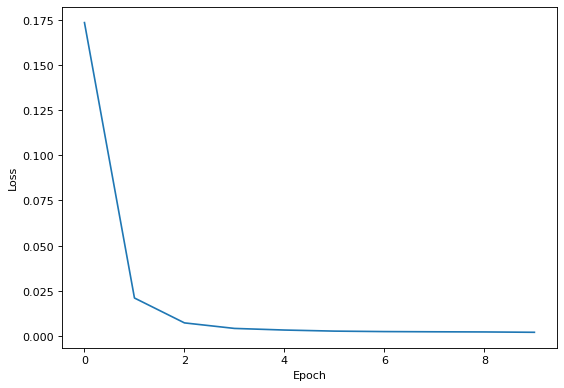

In [5]:
model = PytorchModel(CNN(2048, 1))
model.train(train_set, 10, weight_decay=0.01)
Plotter.loss(model)

### 做出预测

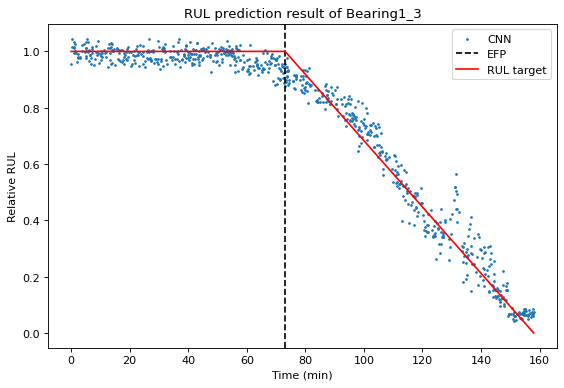

'RUL prediction result of Bearing1_3'

In [6]:
result = model.test(test_set)
Plotter.rul_end2end(test_set, result, label_x='Time (min)', label_y='Relative RUL')

### 预测结果评价

In [7]:
evaluator = Evaluator()
evaluator.add(MAE(), MSE(), RMSE(), PercentError(), PHM2012Score(), PHM2008Score())
evaluator(test_set, result)

INFO - 18:00:02 >> 
<< Performance Evaluation of Bearing1_3:
	MAE: 0.0366
	MSE: 0.0024
	RMSE: 0.0492
	Percent Error: 0.24%
	PHM2012 Score: 0.6792
	PHM2008 Score: 2.4484


{'MAE': 0.036576505978121475,
 'MSE': 0.0024213656947625426,
 'RMSE': 0.04920737439411437,
 'Percent Error': 0.23699788280007214,
 'PHM2012 Score': 0.6792209760792851,
 'PHM2008 Score': 2.448375481312847}